##### Grading Feedback
92%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- Students are responsible for reading the usage comments and understanding how to properly use the get_training_filename() function.  Runtime errors which result from incorrect usage of get_training_filename() shall result in a  point reduction.  
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.  Heavy weight operations that convert data to pandas or spark (like collect()) will result in a point reduction.__

### Wine Analysis
I'm a big fan of wine and would love to use visualizations, machine learning, and inference to learn more about the characteristics of a good wine and predict good wines.  Unfortunately I'm too busy (and lazy) to do the analysis myself but I do have just under 60 trained data scientests at my disposal to do the research for me.  The data set contains the following columns:<br>

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [1]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
# import packages

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import functions as fn
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Question 1 Data Wrangling: (10 pts)
Read the winequality-red.csv data set into a spark data frame named wine_df.  Use the get_training_filename function provided above to determine the appropriate file path based on the platform on which you are running. Check the resulting data frame for NA / NAN values and deal with these problems appropriately.  Note that the target variable has 10 classes.  Convert the 10 classes into 2 classes.  If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine.  If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.

In [3]:
# students shall create wine_df here
# Read the winequality-red.csv data set into a spark data frame named wine_df. 
wine_df = spark.read.csv(get_training_filename('winequality-red.csv'), 
                                         header=True, inferSchema=True)

In [4]:
# grading cell: students shall print the head and shape of wine_df here
print('The shape of wine_df is: '
      ,wine_df.count()
      ,"rows, "
      ,len(wine_df.columns),"columns.")

display(wine_df.limit(5).toPandas())

The shape of wine_df is:  1599 rows,  12 columns.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# grading cell: students shall prove that there are no NA / NAN values in the wine_df here
# Check the resulting data frame for NA / NAN values.
# check each column
display(wine_df.select([count(when(col(c).isNull(), c)).alias(c) for c in wine_df.columns]).toPandas())
# add all the NAs in each column
display(wine_df.select(sum([count(when(col(c).isNull(), c)).alias(c) for c in wine_df.columns]).alias('total NAs')).toPandas())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,0,0,0,0,0,0,0,0,0,0,0


,total NAs
0,0


In [6]:
# understand the structure and summary of the data 
# wine_df.printSchema()
# wine_df.describe().toPandas()
# wine_df.groupBy('quality').count().show()

In [7]:
# Convert the 10 classes into 2 classes. 
# If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine. 
# If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.
wine_df = wine_df.withColumn("quality",fn.when(fn.col("quality")>=7, 1).otherwise(0))

# wine_df.groupBy('label').count().show() gives us 1382 "0" and 217 "1".
print("The number of good wine samples is:",wine_df.where(fn.col("quality") == 1).count())
print("The number of lower quality wine samples is:",wine_df.where(fn.col("quality") == 0).count())

The number of good wine samples is: 217
The number of lower quality wine samples is: 1382


In [8]:
# rename target 'quality' col to 'label' for further analysis
wine_df =wine_df.withColumnRenamed('quality', 'label')

##### Grading feedback cell

# Question 2 Visualizations (10 pts)
I am interested to know more about the data set.  Create one or more visualizations that summarize the data.  Write a short description that helps me understand the visualizations.  Tell me something interesting or surprising about the data.

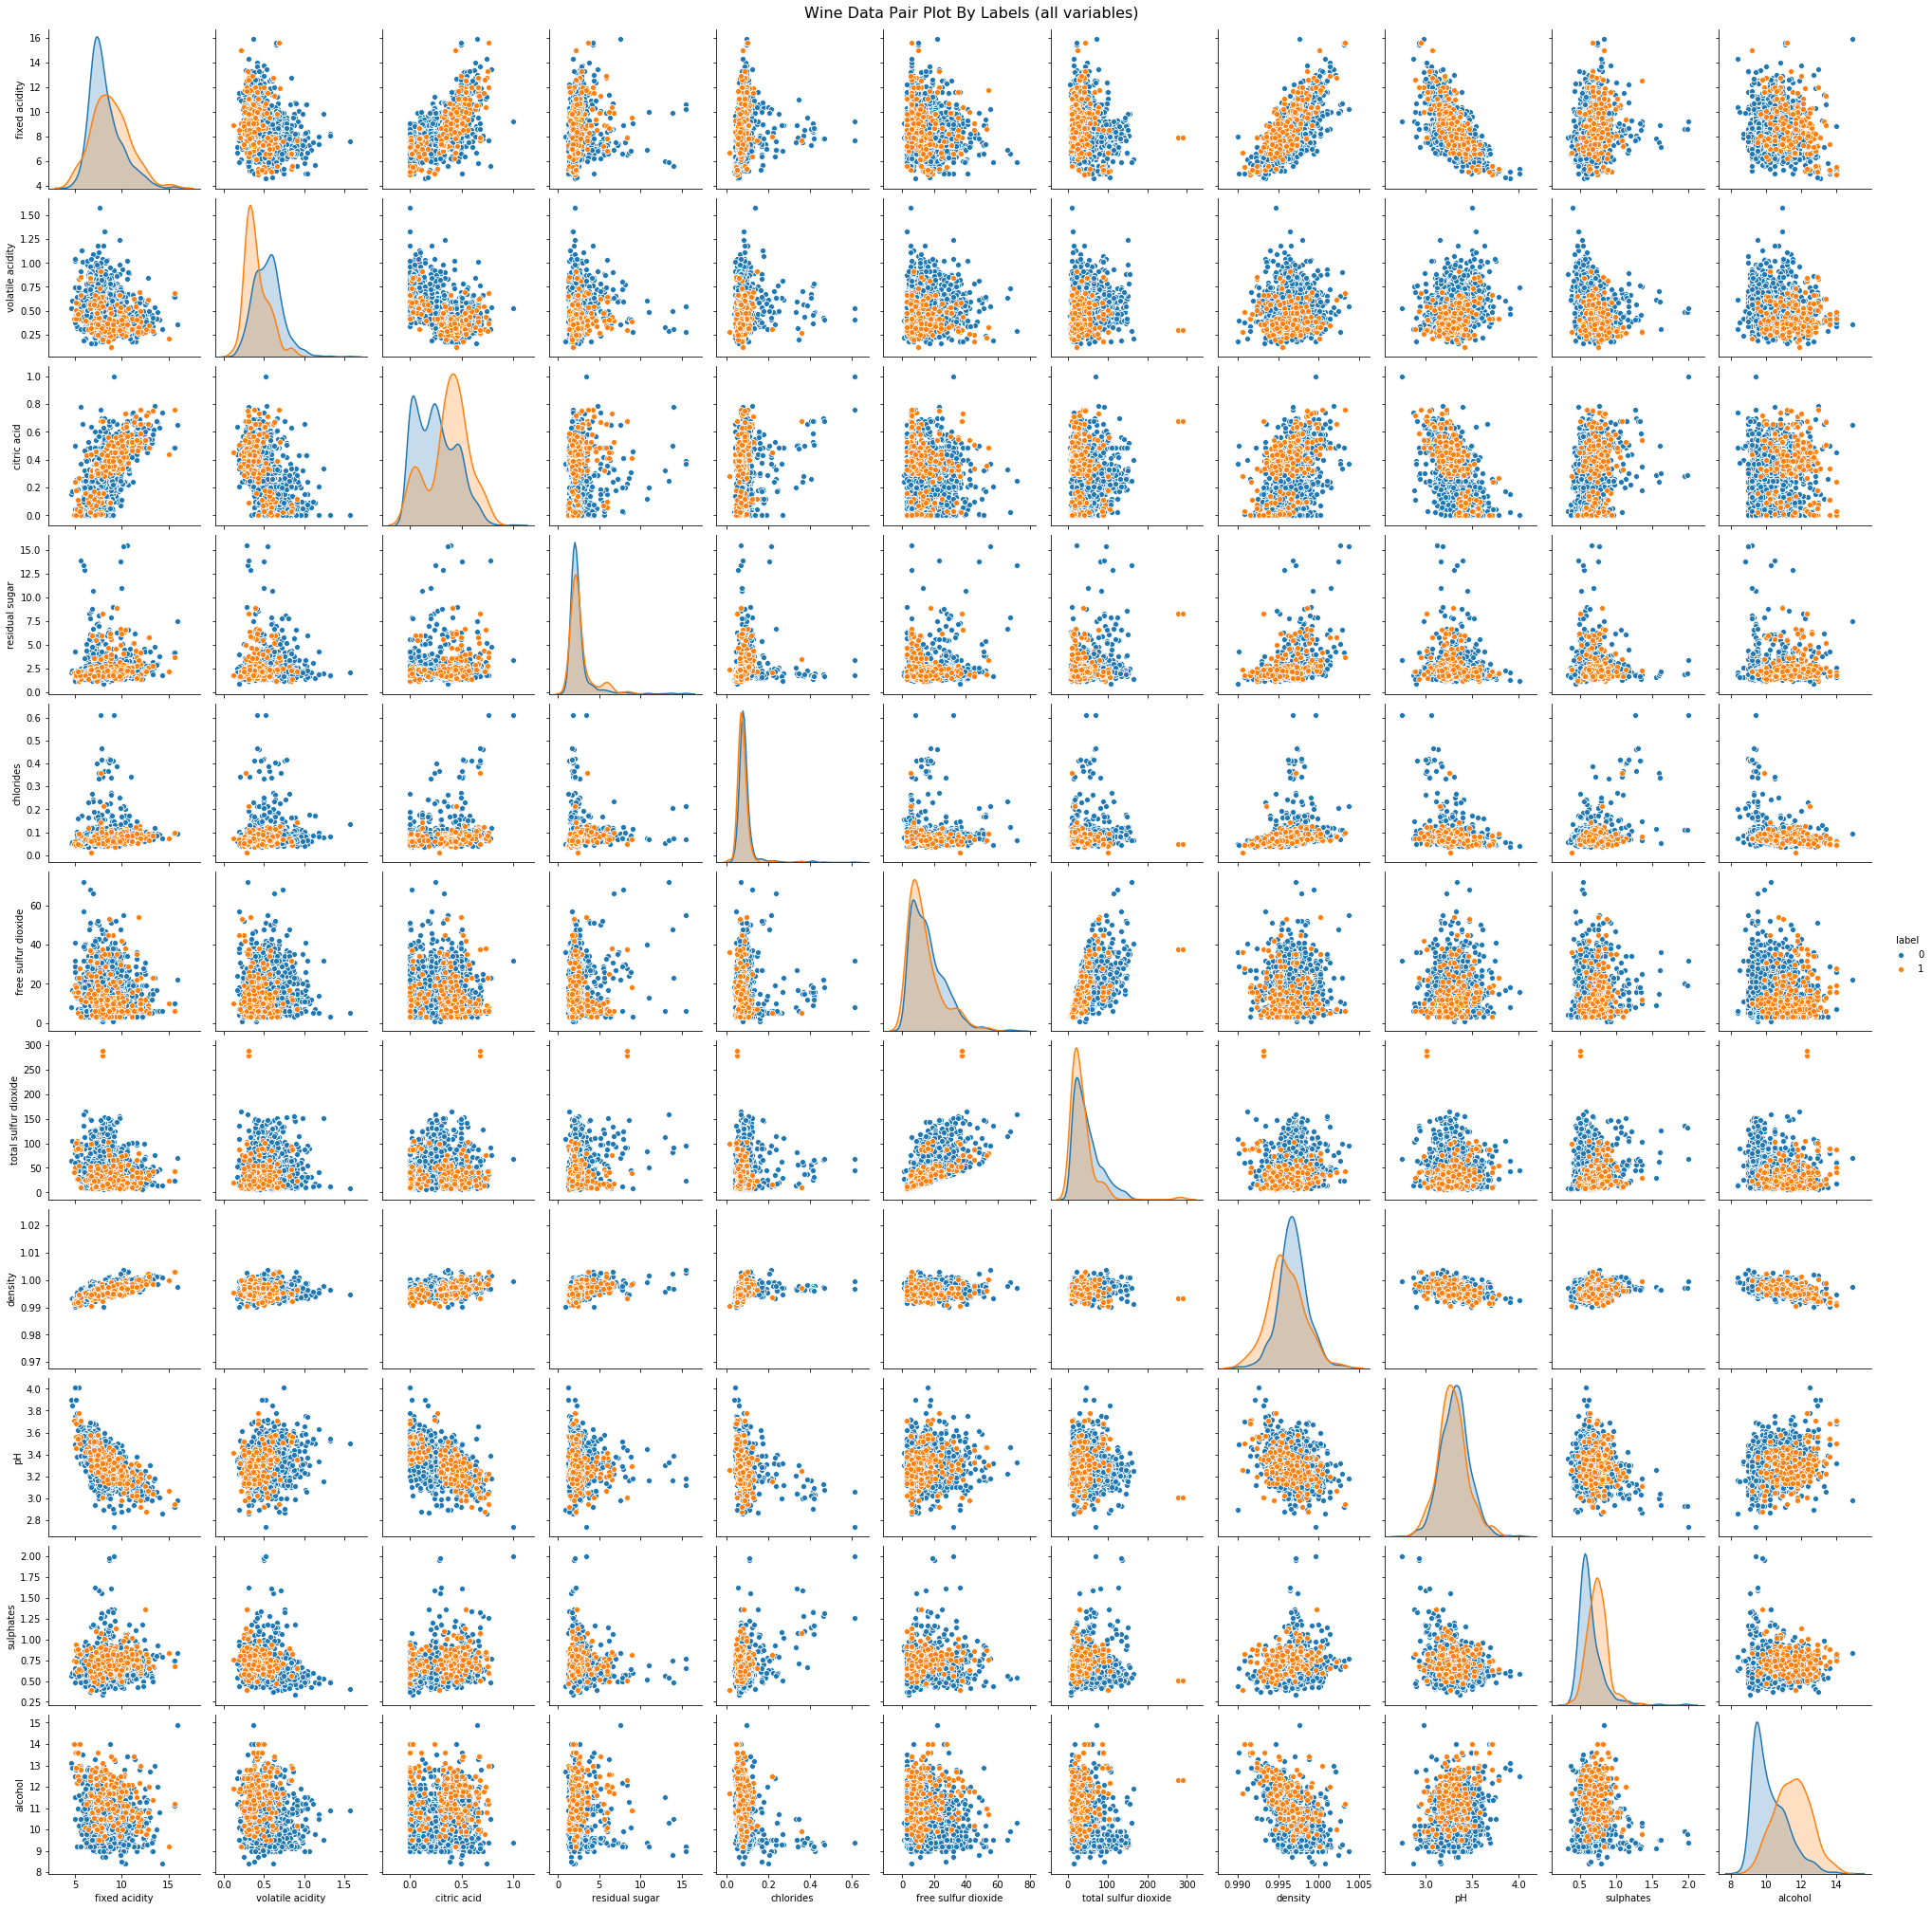

In [9]:
# your code here
# convert the df to pandas df for visualization
data=wine_df.toPandas()

# Create a pair plot for all the variables in the wine data
g = sns.pairplot(data, hue="label", vars=data.columns[0:-1])
g.fig.suptitle("Wine Data Pair Plot By Labels (all variables)", y=1.01,fontsize=16);

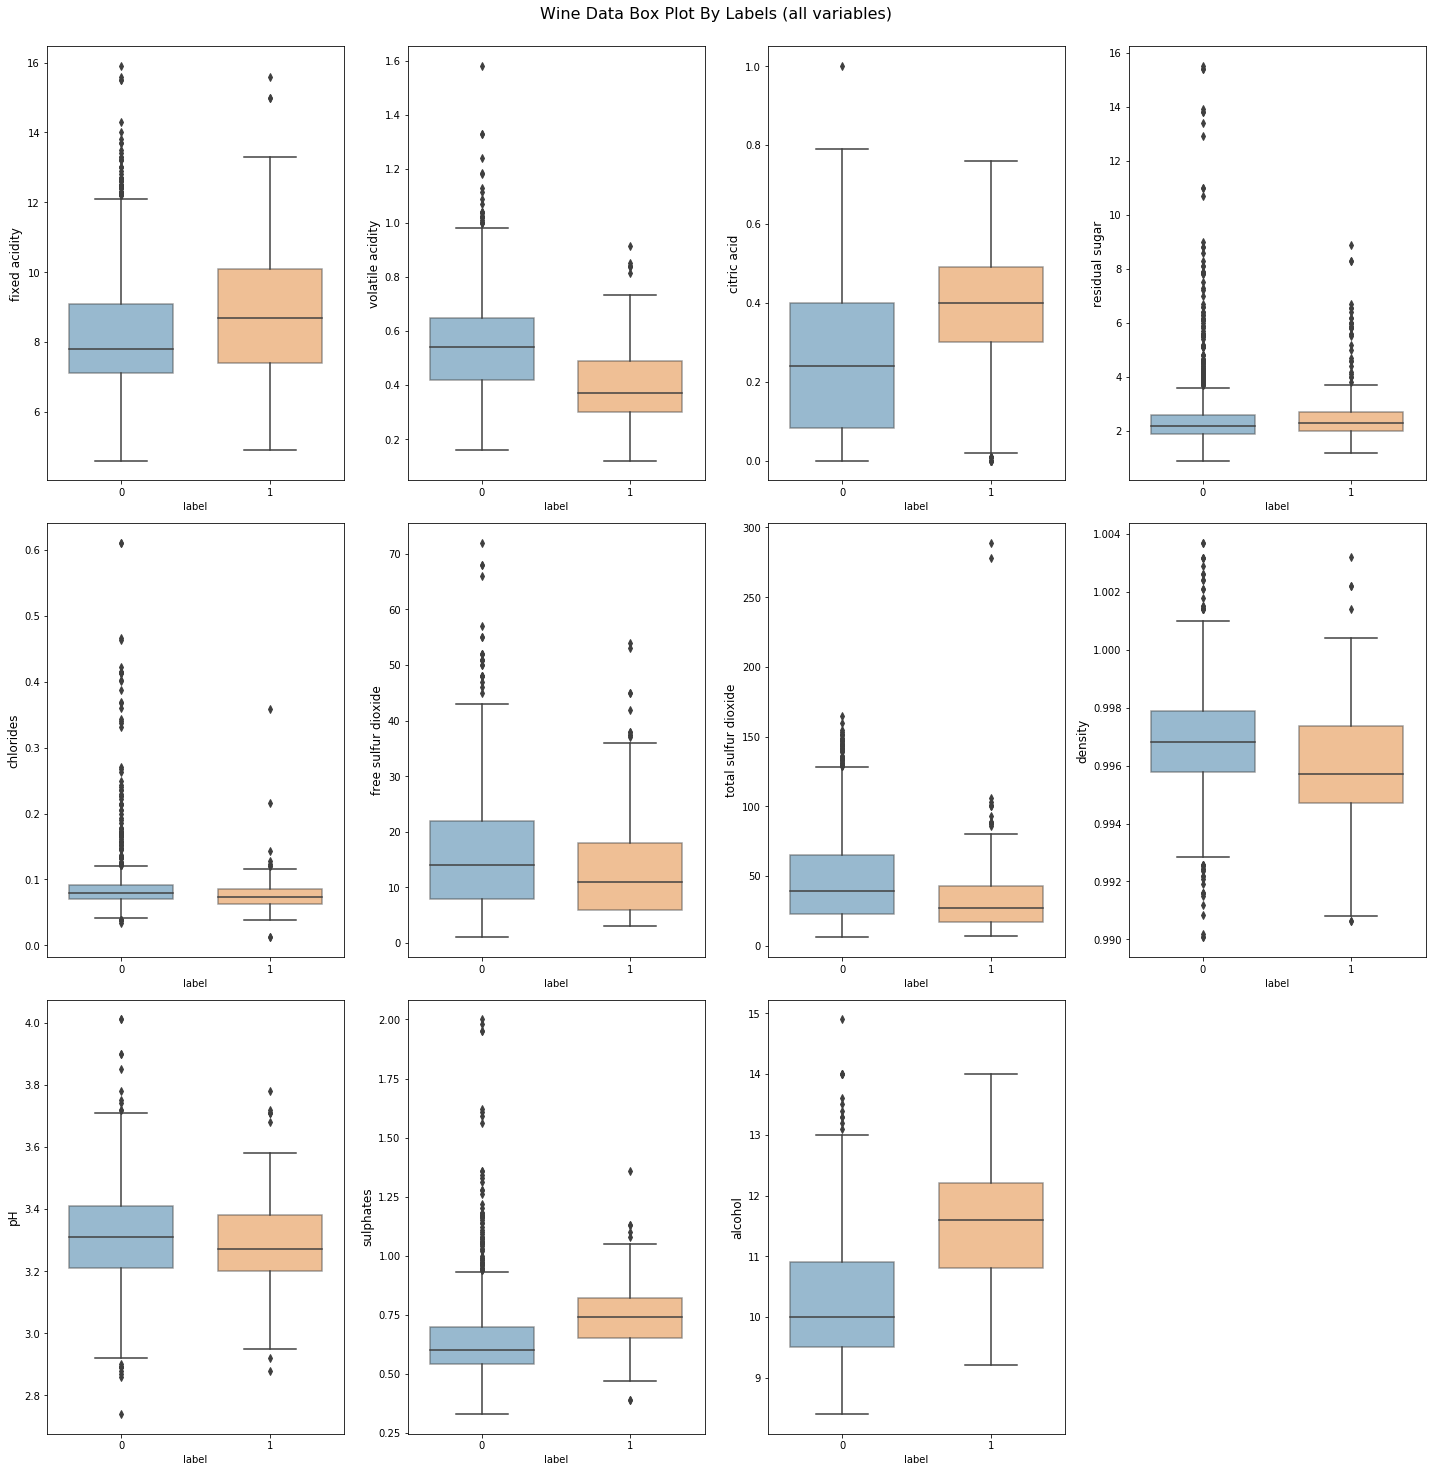

In [10]:
# Create a box plot for all the variables 
colum=data.columns.tolist()
fig=plt.figure(figsize=(20,20))

for i in range(11):
    plt.subplot(3,4,i+1)
    sns.boxplot(x=data['label'],y=data[colum[i]],orient="v",width=0.7,boxprops=dict(alpha=.5)) #,hue=data['label']
    plt.ylabel(colum[i],fontsize=12)
    
plt.tight_layout()
fig.suptitle("Wine Data Box Plot By Labels (all variables)", y=1.02,fontsize=16);

c:\IronKey\DeveloperTools\anaconda3.5.0.1\envs\ist718\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


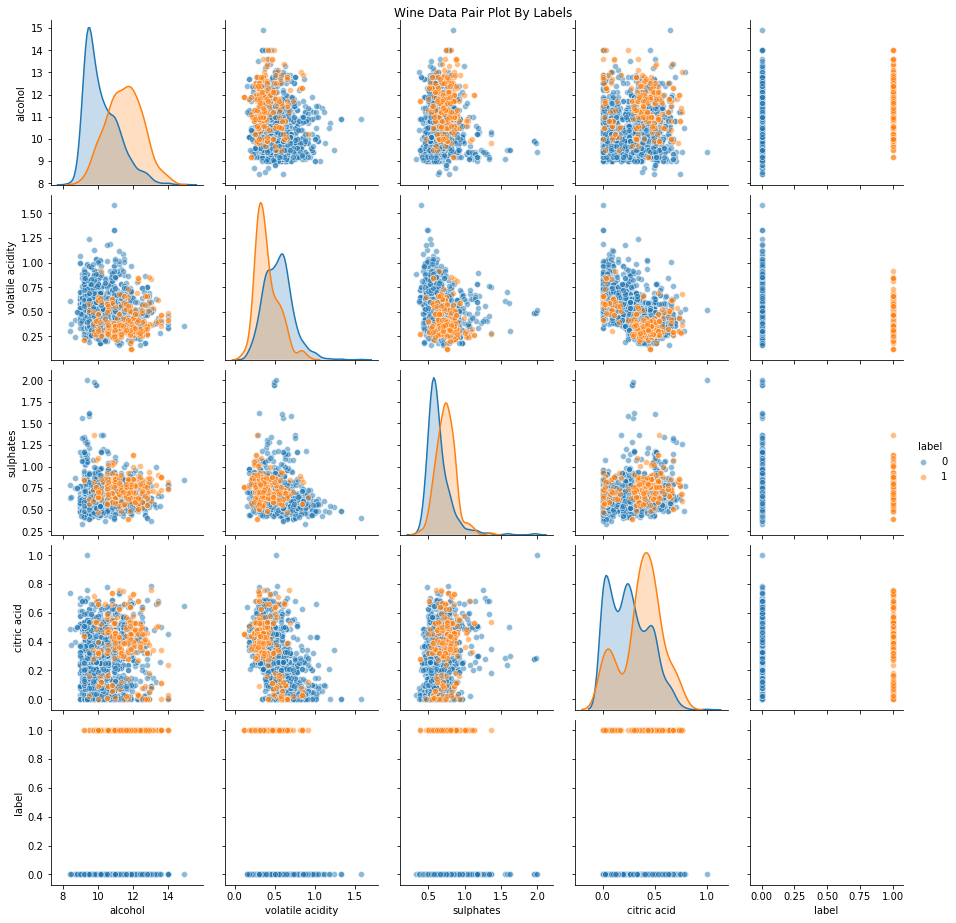

In [11]:
# your code here
# Create a pair plot for some variables that might be helpful for calssification
g = sns.pairplot(data, hue='label',vars=['alcohol','volatile acidity','sulphates','citric acid', 'label'],plot_kws=dict(alpha=0.5));
g.fig.suptitle("Wine Data Pair Plot By Labels", y=1.01);

In [42]:
# Histogram for all the variables

# colum=data.columns.tolist()
# fig=plt.figure(figsize=(20,20))

# for i in range(11):
#     plt.subplot(4,3,i+1)
#     data[colum[i]].hist(color='steelblue',alpha=0.5) #bins=100
#     plt.xlabel(colum[i],fontsize=12)
# plt.tight_layout()
# fig.suptitle("Wine Data Histograms (all variables)", y=1.02,fontsize=16);

Your short description here:<br>

As we can see in the box plot, the values of variables 'alcohol','volatile acidity','sulphates','citric acid' are significantly different between high and low quality wines, which indicates that these variables might be very helpfui for the wine classification problem. 

The box plot also shows that low quality wines tend to have more outliers on most variables than high quality wines, which indicates that the quality control of high quality wines is better than low quality wines.

The pair plot shows the relationship between these varibales and the wine quality. For example, high quality wines tend to have a higher alcohol, sulphates, citric acid. Low quality wines tend to have a higher volatile acidity. We can make an assumption baesd on these plots that there is a positive correlation between wine quantity and alcohol, sulphates, citric acid, there is a negative correlation between wine quantity and volatile acidity.

##### Grading Feedback

# Random Forest

# Question 3: (10 pts)
Create a spark RandomForestClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [43]:
# split the wine dataframe into training and testing dataframes
training_df, testing_df = wine_df.randomSplit([0.8, 0.2],0)

In [44]:
# Your code here
# create a vector assembler
va = VectorAssembler().setInputCols(training_df.columns[:11]).setOutputCol('features')
# create a RandomForestClassifier using all default parameters
rf = RandomForestClassifier()
# create an evaluator using a BinaryClassificationEvaluator.
bce = BinaryClassificationEvaluator()

# create a pipeline
rf_pipeline=Pipeline(stages=[va,rf])
# Fit the Random Forest model on the training data
rf_model=rf_pipeline.fit(training_df)

# Print the AUC accuracy of the test data 
print("The AUC score of RandomForestClassifier using all default parameters is:\n")
print(bce.evaluate(rf_model.transform(testing_df)))

The AUC score of RandomForestClassifier using all default parameters is:

0.8489518147684595


##### Grading Feedback

# Question 4: (10 pts)
Use spark RandomForestClassifier, ParamGridBuilder, and CrossValidator objects to perform a random forest grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default random forest model above.  You are free to choose any hyper parameters you want in your grid search.  You should be able to achieve an AUC score around / above 88%. 

In [45]:
# Your grid search code here
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20,50]) \
    .addGrid(rf.impurity, ["entropy","gini"]) \
    .addGrid(rf.maxDepth, [20,30]) \
    .addGrid(rf.featureSubsetStrategy,['all','sqrt']) \
    .build()

# I also tried .addGrid(rf.minInstancesPerNode,[1,3,5]) and "1" gives us the best performance.
# maxDepth=50 is not acceptable because DecisionTree currently only supports maxDepth <= 30.
# len(paramGrid) is 16

# Define an evaluator and a CrossValidator. 
# The CrossValidator performs cross validation on each model in the grid defined above. 
rf_crossval = CrossValidator(estimator=rf_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=bce, 
                          numFolds=3)

# Fit the Random Forest Cross Validator model on the training data
rf_cv_model = rf_crossval.fit(training_df)

# Print the AUC accuracy of the test data 
rf_auc=bce.evaluate(rf_cv_model.bestModel.transform(testing_df))

print("The AUC score of RandomForestClassifier using grid search is:\n")
print(rf_auc)

The AUC score of RandomForestClassifier using grid search is:

0.9068757822277848


##### Grading Feedback
I did not know that the max tree depth was limited to 30.  I was skeptical about that claim and tried it myself and found your statement to be true.  Its kind of lame that the max tree depth cannot grow beyond 30.

# Question 5 (10 pts)
Extract the cross validation AUC score and specific hyper parameters used from the grid search above.  Create a pandas dataframe where the first column is the grid parameter name and the 2nd colum is the grid parameter value.  Make the last row of the pandas data frame the resulting AUC score.  Print the pandas data frame.  Describe in words in the markdown cell below what specific parameters you used in your grid and what those parameters do in the model.  For example, if you specified impurity in your grid, describe what impurity does in the random forest.  Keep the descriptions brief and at a high level, I'm just trying to see if you understand the high level concept of what the tuning parameter does.

In [46]:
# Print the pandas data frame here
rf_best_model=rf_cv_model.bestModel
best_parameter=pd.DataFrame({ 
             'numTrees': rf_best_model.stages[-1].getNumTrees, 
             'maxDepth':rf_best_model.stages[-1]._java_obj.getMaxDepth(),
             'impurity':rf_best_model.stages[-1]._java_obj.getImpurity(),
             'featureSubsetStrategy':rf_best_model.stages[-1]._java_obj.getFeatureSubsetStrategy(),
             'AUC':rf_auc}, index=[0]).T
best_parameter.columns = ['parameter value']
best_parameter.index.name = 'parameter'
best_parameter

,parameter value
parameter,
numTrees,50
maxDepth,20
impurity,entropy
featureSubsetStrategy,sqrt
AUC,0.906876


In [47]:
# display the parameters and AUC for all of the models in the grid search
tree_list = []
depth_list  = []
feature_list = []
impurity_list = []


def parameter_getter(model):
    for i in range(len(model.getEstimatorParamMaps())):
        for k in model.getEstimatorParamMaps()[i].keys():
            if k.name =='numTrees':
                tree_list.append(model.getEstimatorParamMaps()[i][k])
            if k.name =='maxDepth':
                depth_list.append(model.getEstimatorParamMaps()[i][k])
            if k.name =='featureSubsetStrategy':
                feature_list.append(model.getEstimatorParamMaps()[i][k])
            if k.name =='impurity': 
                impurity_list.append(model.getEstimatorParamMaps()[i][k])
    
    metrics = model.avgMetrics
                
    results_df =  pd.DataFrame({ 
             'numTrees': tree_list, 
             'maxDepth':depth_list,
             'impurity':impurity_list,
             'featureSubsetStrategy':feature_list,
             'AUC':metrics})
    
    results_df =  results_df.T
    results_df.columns = [str(i+1)+' grid search' for i in range(results_df.shape[1])]
    results_df.index.name = 'parameter'
    
    return results_df

rf_cv_parameter=parameter_getter(rf_cv_model)
rf_cv_parameter

,1 grid search,2 grid search,3 grid search,4 grid search,5 grid search,6 grid search,7 grid search,8 grid search,9 grid search,10 grid search,11 grid search,12 grid search,13 grid search,14 grid search,15 grid search,16 grid search
parameter,,,,,,,,,,,,,,,,
numTrees,20,20,20,20,20,20,20,20,50,50,50,50,50,50,50,50
maxDepth,20,20,30,30,20,20,30,30,20,20,30,30,20,20,30,30
impurity,entropy,entropy,entropy,entropy,gini,gini,gini,gini,entropy,entropy,entropy,entropy,gini,gini,gini,gini
featureSubsetStrategy,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt
AUC,0.89271,0.888895,0.89271,0.888895,0.885193,0.888578,0.885193,0.888578,0.894392,0.904925,0.894392,0.904925,0.895591,0.89302,0.895591,0.89302


Write your grid search parameter descriptions here:<br>

**The specific parameters I used in my grid are: numTrees, maxDepth, impurity and featureSubsetStrategy.**<br>

1. numTrees controls Number of trees in the forest. Increasing the number of trees will decrease the variance in predictions, improving the model’s test-time accuracy. Training time increases roughly linearly in the number of trees. I choose 10,20,50 and 50 gives me the best performance.<br>
<br>
2. maxDepth controls Maximum depth of each tree in the forest. Increasing the depth makes the model more expressive and powerful. However, deep trees take longer to train and are also more prone to overfitting. In general, it is acceptable to train deeper trees when using random forests than when using a single decision tree. One tree is more likely to overfit than a random forest. I choose 20,30 and 20 gives me the best performance.<br>
<br>
3. impurity controls the criterion used for information gain calculation. I tried both "entropy" and "gini", the former give me the best performance. <br>
<br>
4. featureSubsetStrategy controls the Number of features to use as candidates for splitting at each tree node. Decreasing this number will speed up training, but can sometimes impact performance if too low. I choose 'all' (use all features) and 'sqrt' (use sqrt(number of features)) and 'sqrt' gives me the best performance. <br>
<br>
Reference: https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests

##### Grading Feedback
- -5: Multiple problems
- I get a runtime error on data bricks and on my PC:  AttributeError: 'RandomForestClassificationModel' object has no attribute 'getMaxDepth' which I fixed.  
- You also did not provide the cross validation AUC score for the first data frame above - you provided the test data score.  No points were deducted for this as the points off was limited to 5 by the runtime error.

# Question 6:  5 pts
Create a pandas dataframe containing 2 columns: feature and importance. Load the feature column with the dataset feature names and the 2nd column with the feature importances as determined by the best model produced by the grid search above. Sort the dataframe by importance in descending order. In the markdown cell, tell me the 3 features that are most important to predicting a good wine.<br>

In [48]:
# Your code here
rf_feature_importance=pd.DataFrame(list(zip(wine_df.columns[:11], rf_best_model.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)
rf_feature_importance

,feature,importance
10,alcohol,0.206626
9,sulphates,0.119442
1,volatile acidity,0.115211
2,citric acid,0.105551
0,fixed acidity,0.082442
6,total sulfur dioxide,0.078031
7,density,0.069707
4,chlorides,0.062974
5,free sulfur dioxide,0.056508
8,pH,0.055245


Your feature importance comments here.<br>
<br>
The 3 features that are most important to predicting a good wine are **alcohol, volatile acidity, sulphates.**

# Question 7:  10 pts.
Print any of the trees in the forest from the final model.  Copy the printed text to the tree printout markdown cell below and retain the same formatting and indentation as the printout so it's easy for the graders to view the data.  Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cells below.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) The top level split indicates the most important predictor in the data set.  Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above. <br>

In [49]:
# your code here
#print(len(rf_cv_model.bestModel.stages[-1].trees))
#print(rf_best_model.stages[-1].trees[0].toDebugString)
print(rf_best_model.stages[-1].trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_5f81aede99cc) of depth 13 with 177 nodes
  If (feature 9 <= 0.675)
   If (feature 7 <= 0.99521)
    If (feature 2 <= 0.295)
     If (feature 1 <= 0.28500000000000003)
      Predict: 1.0
     Else (feature 1 > 0.28500000000000003)
      If (feature 5 <= 8.5)
       Predict: 0.0
      Else (feature 5 > 8.5)
       If (feature 6 <= 15.5)
        Predict: 1.0
       Else (feature 6 > 15.5)
        If (feature 6 <= 98.5)
         If (feature 3 <= 2.225)
          Predict: 0.0
         Else (feature 3 > 2.225)
          If (feature 4 <= 0.0645)
           If (feature 1 <= 0.7224999999999999)
            If (feature 8 <= 3.435)
             If (feature 8 <= 3.335)
              Predict: 0.0
             Else (feature 8 > 3.335)
              Predict: 1.0
            Else (feature 8 > 3.435)
             Predict: 0.0
           Else (feature 1 > 0.7224999999999999)
            Predict: 1.0
          Else (feature 4 > 0.0645)
           Predict: 0.0
    

In [50]:
print("The feature importance of tree 0 is")
rf_tree_feature_importance=pd.DataFrame(list(zip(wine_df.columns[:11], rf_best_model.stages[-1].trees[0].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)
rf_tree_feature_importance
#rf_best_model.stages[-1].trees[0].featureImportances

The feature importance of tree 0 is


,feature,importance
6,total sulfur dioxide,0.147599
9,sulphates,0.145733
7,density,0.113516
10,alcohol,0.109954
2,citric acid,0.108281
0,fixed acidity,0.081735
4,chlorides,0.072284
3,residual sugar,0.061067
1,volatile acidity,0.060270
8,pH,0.054499


##### Grading Feedback

In [51]:
# Paste the tree printout in this cell:

# DecisionTreeClassificationModel: uid=dtc_1fa164205297, depth=16, numNodes=173, numClasses=2, numFeatures=11
#   If (feature 2 <= 0.315)
#    If (feature 10 <= 11.55)
#     If (feature 6 <= 30.5)
#      If (feature 3 <= 4.55)
#       If (feature 1 <= 0.435)
#        If (feature 4 <= 0.07050000000000001)
#         If (feature 3 <= 1.6749999999999998)
#          Predict: 0.0
#         Else (feature 3 > 1.6749999999999998)
#          If (feature 4 <= 0.0495)
#           Predict: 0.0
#          Else (feature 4 > 0.0495)
#           Predict: 1.0
#        Else (feature 4 > 0.07050000000000001)
#         Predict: 0.0
#       Else (feature 1 > 0.435)
#        If (feature 10 <= 9.975)
#         Predict: 0.0
#        Else (feature 10 > 9.975)
#         If (feature 6 <= 14.5)
#          Predict: 0.0
#         Else (feature 6 > 14.5)
#          If (feature 7 <= 0.996405)
#           If (feature 7 <= 0.996305)
#            If (feature 6 <= 21.5)
#             If (feature 1 <= 0.595)
#              Predict: 1.0
#             Else (feature 1 > 0.595)
#              If (feature 7 <= 0.99479)
#               Predict: 1.0
#              Else (feature 7 > 0.99479)
#               Predict: 0.0
#            Else (feature 6 > 21.5)
#             Predict: 0.0
#           Else (feature 7 > 0.996305)
#            If (feature 10 <= 10.25)
#             If (feature 8 <= 3.355)
#              Predict: 1.0
#             Else (feature 8 > 3.355)
#              Predict: 0.0
#            Else (feature 10 > 10.25)
#             Predict: 1.0
#          Else (feature 7 > 0.996405)
#           Predict: 0.0
#      Else (feature 3 > 4.55)
#       If (feature 1 <= 0.595)
#        Predict: 1.0
#       Else (feature 1 > 0.595)
#        If (feature 6 <= 11.5)
#         Predict: 1.0
#        Else (feature 6 > 11.5)
#         Predict: 0.0
#     Else (feature 6 > 30.5)
#      If (feature 9 <= 0.825)
#       Predict: 0.0
#      Else (feature 9 > 0.825)
#       If (feature 9 <= 0.865)
#        If (feature 0 <= 8.649999999999999)
#         Predict: 0.0
#        Else (feature 0 > 8.649999999999999)
#         Predict: 1.0
#       Else (feature 9 > 0.865)
#        Predict: 0.0
#    Else (feature 10 > 11.55)
#     If (feature 9 <= 0.675)
#      If (feature 7 <= 0.9943949999999999)
#       Predict: 0.0
#      Else (feature 7 > 0.9943949999999999)
#       If (feature 6 <= 42.5)
#        Predict: 0.0
#       Else (feature 6 > 42.5)
#        If (feature 5 <= 28.5)
#         If (feature 0 <= 5.85)
#          Predict: 1.0
#         Else (feature 0 > 5.85)
#          Predict: 0.0
#        Else (feature 5 > 28.5)
#         Predict: 1.0
#     Else (feature 9 > 0.675)
#      If (feature 5 <= 18.5)
#       Predict: 1.0
#      Else (feature 5 > 18.5)
#       If (feature 3 <= 1.85)
#        Predict: 0.0
#       Else (feature 3 > 1.85)
#        Predict: 1.0
#   Else (feature 2 > 0.315)
#    If (feature 7 <= 0.99621)
#     If (feature 0 <= 6.75)
#      Predict: 0.0
#     Else (feature 0 > 6.75)
#      If (feature 3 <= 3.1500000000000004)
#       If (feature 6 <= 13.5)
#        If (feature 9 <= 0.525)
#         Predict: 0.0
#        Else (feature 9 > 0.525)
#         If (feature 4 <= 0.10350000000000001)
#          Predict: 1.0
#         Else (feature 4 > 0.10350000000000001)
#          Predict: 0.0
#       Else (feature 6 > 13.5)
#        If (feature 2 <= 0.325)
#         Predict: 0.0
#        Else (feature 2 > 0.325)
#         If (feature 9 <= 0.655)
#          If (feature 5 <= 22.5)
#           Predict: 0.0
#          Else (feature 5 > 22.5)
#           Predict: 1.0
#         Else (feature 9 > 0.655)
#          If (feature 7 <= 0.99385)
#           Predict: 1.0
#          Else (feature 7 > 0.99385)
#           If (feature 5 <= 17.5)
#            If (feature 1 <= 0.455)
#             If (feature 0 <= 10.45)
#              If (feature 9 <= 0.715)
#               If (feature 8 <= 3.225)
#                Predict: 1.0
#               Else (feature 8 > 3.225)
#                Predict: 0.0
#              Else (feature 9 > 0.715)
#               If (feature 5 <= 10.5)
#                Predict: 1.0
#               Else (feature 5 > 10.5)
#                If (feature 8 <= 3.115)
#                 Predict: 0.0
#                Else (feature 8 > 3.115)
#                 If (feature 6 <= 45.5)
#                  Predict: 1.0
#                 Else (feature 6 > 45.5)
#                  If (feature 8 <= 3.375)
#                   Predict: 0.0
#                  Else (feature 8 > 3.375)
#                   Predict: 1.0
#             Else (feature 0 > 10.45)
#              Predict: 0.0
#            Else (feature 1 > 0.455)
#             Predict: 0.0
#           Else (feature 5 > 17.5)
#            If (feature 8 <= 3.395)
#             If (feature 8 <= 3.1950000000000003)
#              If (feature 1 <= 0.355)
#               If (feature 5 <= 19.5)
#                Predict: 1.0
#               Else (feature 5 > 19.5)
#                Predict: 0.0
#              Else (feature 1 > 0.355)
#               Predict: 1.0
#             Else (feature 8 > 3.1950000000000003)
#              If (feature 4 <= 0.0495)
#               If (feature 5 <= 25.5)
#                Predict: 0.0
#               Else (feature 5 > 25.5)
#                If (feature 0 <= 7.95)
#                 Predict: 0.0
#                Else (feature 0 > 7.95)
#                 Predict: 1.0
#              Else (feature 4 > 0.0495)
#               Predict: 0.0
#            Else (feature 8 > 3.395)
#             If (feature 6 <= 37.5)
#              Predict: 0.0
#             Else (feature 6 > 37.5)
#              Predict: 1.0
#      Else (feature 3 > 3.1500000000000004)
#       Predict: 1.0
#    Else (feature 7 > 0.99621)
#     If (feature 10 <= 9.649999999999999)
#      Predict: 0.0
#     Else (feature 10 > 9.649999999999999)
#      If (feature 6 <= 53.5)
#       If (feature 9 <= 0.755)
#        If (feature 1 <= 0.385)
#         If (feature 6 <= 18.5)
#          If (feature 0 <= 10.45)
#           If (feature 9 <= 0.485)
#            Predict: 0.0
#           Else (feature 9 > 0.485)
#            Predict: 1.0
#          Else (feature 0 > 10.45)
#           Predict: 0.0
#         Else (feature 6 > 18.5)
#          Predict: 0.0
#        Else (feature 1 > 0.385)
#         If (feature 3 <= 2.625)
#          If (feature 10 <= 9.75)
#           Predict: 1.0
#          Else (feature 10 > 9.75)
#           Predict: 0.0
#         Else (feature 3 > 2.625)
#          If (feature 4 <= 0.1205)
#           If (feature 10 <= 10.01666666666665)
#            Predict: 1.0
#           Else (feature 10 > 10.01666666666665)
#            If (feature 7 <= 0.996305)
#             Predict: 1.0
#            Else (feature 7 > 0.996305)
#             Predict: 0.0
#          Else (feature 4 > 0.1205)
#           Predict: 1.0
#       Else (feature 9 > 0.755)
#        If (feature 2 <= 0.525)
#         If (feature 4 <= 0.0955)
#          If (feature 4 <= 0.08249999999999999)
#           If (feature 4 <= 0.0785)
#            If (feature 10 <= 12.05)
#             If (feature 8 <= 3.255)
#              If (feature 3 <= 2.125)
#               If (feature 2 <= 0.475)
#                If (feature 5 <= 9.5)
#                 Predict: 1.0
#                Else (feature 5 > 9.5)
#                 Predict: 0.0
#               Else (feature 2 > 0.475)
#                Predict: 0.0
#              Else (feature 3 > 2.125)
#               Predict: 0.0
#             Else (feature 8 > 3.255)
#              Predict: 0.0
#            Else (feature 10 > 12.05)
#             Predict: 1.0
#           Else (feature 4 > 0.0785)
#            Predict: 0.0
#          Else (feature 4 > 0.08249999999999999)
#           Predict: 1.0
#         Else (feature 4 > 0.0955)
#          Predict: 0.0
#        Else (feature 2 > 0.525)
#         If (feature 2 <= 0.575)
#          Predict: 1.0
#         Else (feature 2 > 0.575)
#          If (feature 5 <= 10.5)
#           If (feature 2 <= 0.645)
#            If (feature 0 <= 11.45)
#             Predict: 1.0
#            Else (feature 0 > 11.45)
#             Predict: 0.0
#           Else (feature 2 > 0.645)
#            Predict: 1.0
#          Else (feature 5 > 10.5)
#           Predict: 0.0
#      Else (feature 6 > 53.5)
#       If (feature 1 <= 0.435)
#        Predict: 0.0
#       Else (feature 1 > 0.435)
#        If (feature 5 <= 28.5)
#         If (feature 8 <= 3.355)
#          Predict: 0.0
#         Else (feature 8 > 3.355)
#          If (feature 4 <= 0.0795)
#           Predict: 0.0
#          Else (feature 4 > 0.0795)
#           Predict: 1.0
#        Else (feature 5 > 28.5)
#         If (feature 0 <= 10.45)
#          Predict: 1.0
#         Else (feature 0 > 10.45)
#          Predict: 0.0

##### Grading Feedback

What specific predictor variable is being split and what is the value that determines the left / right split:

The variable '**citric acid**' is being split, and the value that determines the left / right split is **0.315**. If the sample has citric acid lower than 0.315, we need to check the variable '**alcohol**', and the value that determines the left / right split of alcohol is **11.55**. If the sample has alcohol lower than 11.55, we need to check the variable '**total sulfur dioxide**', and the value that determines the left / right split of total sulfur dioxide is **30.5** and so on. 

##### Grading Feedback

Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above:<br>

The top level predictor from the cross validated model is calculated by recording the out-of-bag error or Gini index for each data point and averaging over the forest. The feature importance is defined as the total decrease in node impurity averaged over all trees of the ensemble.

At each split in each tree, the improvement in the split-criterion is the importance measure attributed to the splitting variable, and is accumulated over all the trees in the forest separately for each variable.

The top level predictor in my printed tree might be different from the cross validated model because it is one single decision tree and it samples both rows(using bagging) and columns. So the top predictor is the feature that decrease the most impurity for this specific training dataset. This decision tree grows very deep and tends to overfit the training sets, i.e. have low bias, but very high variance. That's why we use Random forests to average multiple deep decision trees, train on different parts of the same training set, with the goal of reducing the variance.

Reference:<br>
https://en.wikipedia.org/wiki/Random_forest#Variable_importance<br>
https://datascience.stackexchange.com/questions/16693/interpreting-decision-tree-in-context-of-feature-importances

##### Grading Feedback

# Question 8:  10 pts.
Create a spark GBTClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [52]:
# Your Code Here
# Create a spark GBTClassifier 
gbt = GBTClassifier()

# create a pipeline
gbt_pipeline = Pipeline(stages=[va, gbt])

# Fit the Random Forest model on the training data
gbt_model=gbt_pipeline.fit(training_df)

# Print the AUC accuracy of the test data 
bce.evaluate(gbt_model.transform(testing_df))

0.8681946182728412

##### Grading Feedback

# Question 9:  10 pts.
Use spark GBTClassifier, ParamGridBuilder, and CrossValidator objects to perform a GBT grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default GBT model and the random forest model above.  You are free to experiment with any search parameters you wish.  It is also okay to experiment with maxIter and stepSize outside of the grid if you wish as long as you comment what you are doing.

In [53]:
# Your Code Here

# Your grid search code here
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.stepSize, [0.01, 0.05, 0.1]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .addGrid(gbt.featureSubsetStrategy,['all','sqrt']) \
    .build()

# The CrossValidator performs cross validation on each model in the grid defined above. 
gbt_crossval = CrossValidator(estimator=gbt_pipeline, 
                              estimatorParamMaps=paramGrid,
                              evaluator=bce, 
                              numFolds=3)

# Fit the Random Forest Cross Validator model on the training data
gbt_cv_model = gbt_crossval.fit(training_df)

# Print the AUC accuracy of the test data 
gbt_auc=bce.evaluate(gbt_cv_model.bestModel.transform(testing_df))

gbt_auc

0.8866551939924873

##### Grading Feedback

# Question 10 10 pts
Create a grid search summary pandas data frame for the GBT grid search exactly like you did in question 5 above.

In [56]:
# Your Code Here
gbt_best_model=gbt_cv_model.bestModel

best_parameter=pd.DataFrame({ 
             'StepSize': gbt_best_model.stages[-1]._java_obj.getStepSize(), 
             'MaxIter':gbt_best_model.stages[-1]._java_obj.getMaxIter(),
             'featureSubsetStrategy':gbt_best_model.stages[-1]._java_obj.getFeatureSubsetStrategy(),
             'AUC':gbt_auc}, index=[0]).T
best_parameter.columns = ['parameter value']
best_parameter.index.name = 'parameter'
best_parameter

# gbt_best_model.stages[-1].getImpurity() gives us 'variance'

,parameter value
parameter,
StepSize,0.1
MaxIter,30
featureSubsetStrategy,sqrt
AUC,0.886655


In [57]:
# display the parameters and AUC for all of the models in the grid search

stepSize_list = []
maxIter_list  = []
feature_list = []


def parameter_getter(model):
    for i in range(len(model.getEstimatorParamMaps())):
        for k in model.getEstimatorParamMaps()[i].keys():
            if k.name =='stepSize':
                stepSize_list.append(model.getEstimatorParamMaps()[i][k])
            if k.name =='maxIter':
                maxIter_list.append(model.getEstimatorParamMaps()[i][k])
            if k.name =='featureSubsetStrategy':
                feature_list.append(model.getEstimatorParamMaps()[i][k])
    
    metrics = model.avgMetrics
                
    results_df =  pd.DataFrame({ 
             'stepSize': stepSize_list, 
             'maxIter':maxIter_list,
             'featureSubsetStrategy':feature_list,
             'AUC':metrics})
    
    results_df =  results_df.T
    results_df.columns = [str(i+1)+' grid search' for i in range(results_df.shape[1])]
    results_df.index.name = 'parameter'
    
    return results_df

gbt_cv_parameter=parameter_getter(gbt_cv_model)
gbt_cv_parameter

,1 grid search,2 grid search,3 grid search,4 grid search,5 grid search,6 grid search,7 grid search,8 grid search,9 grid search,10 grid search,11 grid search,12 grid search
parameter,,,,,,,,,,,,
stepSize,0.01,0.01,0.01,0.01,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1
maxIter,20,20,30,30,20,20,30,30,20,20,30,30
featureSubsetStrategy,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt,all,sqrt
AUC,0.833902,0.853573,0.837497,0.859349,0.860804,0.877548,0.865573,0.884071,0.876723,0.879875,0.878098,0.885443


##### Grading Feedback
- Same runtime error as above fixed by the grader
- -3 did not provide cross validated AUC for best model summary data frame.

Add search parameter comments here


Write your grid search parameter descriptions here:<br>

**The specific parameters I used in my grid are: stepSize, maxIter and featureSubsetStrategy.**<br>

1. stepSize (a.k.a. learning rate) is for shrinking the contribution of each estimator. Empirically it has been found that using small learning rates (such as < 0.1) yields dramatic improvements in models' generalization ability over gradient boosting without shrinking. However, it comes at the price of increasing computational time during training: lower learning rate requires more iterations.I choose 0.01,0.02,0.10 and 0.10 gives me the best performance.<br>
<br>
2. maxIter	 controls the number of trees in the ensemble. Each iteration produces one tree. Increasing this number makes the model more expressive, improving training data accuracy. I choose 20,30 and 30 gives me the best performance.<br>
<br>
3. featureSubsetStrategy controls the Number of features to use as candidates for splitting at each tree node. Decreasing this number will speed up training, but can sometimes impact performance if too low. I choose 'all' (use all features) and 'sqrt' (use sqrt(number of features)) and 'all' gives me the best performance. <br>
<br>

4. I also tried to adjust the impurity, however, accroding to https://stackoverflow.com/questions/53493302/parameter-impurity-given-invalid-value-gini, gini and entropy are not available for GBTClassifier, variance is the only one according to the docs 
https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.ml.regression.RandomForestRegressor. Gini and entropy are options available with random forest classification.<br>
<br>
Reference: <br>
https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests<br>
https://en.wikipedia.org/wiki/Gradient_boosting<br>

# Question 11 (5 pts):
Create and print a pandas dataframe with the columns `feature` and `importance` just like question 6 above.  Also, compare the feature importances to random forest from question 6 above - how different or similar are the feature importances between GBT and random forest.

In [58]:
# Your code here
gbt_feature_importance=pd.DataFrame(list(zip(wine_df.columns[:11], gbt_best_model.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)
gbt_feature_importance

,feature,importance
10,alcohol,0.137026
1,volatile acidity,0.114929
9,sulphates,0.110079
2,citric acid,0.103583
4,chlorides,0.093898
0,fixed acidity,0.089541
6,total sulfur dioxide,0.084157
7,density,0.082171
5,free sulfur dioxide,0.064511
8,pH,0.063781


Feature importance comments here:<br>
The 3 features that are most important to predicting a good wine are **sulphates, alcohol and volatile acidity**.

Add feature importance comparison comments here:<br>

The most important 3 features 'sulphates', 'alcohol' and 'volatile acidity' are the same for both GBT and random forest, although the order is slightly different. 

For the least important features, chlorides, density and pH are not that important in both models and their ranks in both models are similar.

Fixed acidity and total sulfur dioxide are moderately important in both models and their ranks in both models are similar.


The significant difference happens to 'citric acid', 'residual sugar' and 'free sulfur dioxide'.'Citric acid' is the 2nd least important feature in GBT model but it is 4th imporatant feature in random forest. While the 5th and 7th imporatant features in GBT model, 'free sulfur dioxide' and 'residual sugar', are the 3rd and 1st least important features in random forest.

I think there are two reasons for the feature importance difference between these two models:
1. Both algorithms include quite a bit of randomness.In Random Forests for example the forest is built using trees grown on randomly sampled attributes and samples.
2. Random Forests and GBT use different metrics for measuring feature importance. Random Forests uses Gini index or Entropy while GBT uses variance (the variance reduction of a node N is defined as the total reduction of the variance of the target variable x due to the split at this node).

##### Grading Feedback
Excellent Analysis!